In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
from plot_functions import *
from sklearn.model_selection import KFold

In [9]:
from create_matrix import *

from tensor_custom_core import *
from create_matrix import *
from tensor_custom_core import *
from degree_days import dds
appliance_index = {appliance: APPLIANCES_ORDER.index(appliance) for appliance in APPLIANCES_ORDER}

APPLIANCES = ['fridge', 'hvac', 'wm', 'mw', 'oven', 'dw']
region = "SanDiego"
year = 2014

import os


def un_normalize(x, maximum, minimum):
    return (maximum - minimum) * x + minimum

In [10]:
n_splits = 10
import sys
case=2
a=2
cost='abs'

In [11]:
def get_tensor_appliance(df, dfc, appliance):
    start, stop = 1, 13
    energy_cols = np.array(
        [['%s_%d' % (appliance, month) for month in range(start, stop)] ]).flatten()
    static_cols = ['area', 'total_occupants', 'num_rooms']
    static_df = df[static_cols]
    static_df = static_df.div(static_df.max())
    weather_values = np.array(dds[2014][region][start - 1:stop - 1]).reshape(-1, 1)

    dfc = df.copy()

    df = dfc[energy_cols]
    col_max = df.max().max()
    col_min = df.min().min()
    # df = (1.0 * (df - col_min)) / (col_max - col_min)
    tensor = df.values.reshape((len(df), 1, stop - start))
    M, N, O = tensor.shape
    return tensor

In [12]:
def get_tensor(df, dfc):
    start, stop = 1, 13
    energy_cols = np.array(
        [['%s_%d' % (appliance, month) for month in range(start, stop)] for appliance in APPLIANCES_ORDER[2:]]).flatten()
    print(energy_cols)
    static_cols = ['area', 'total_occupants', 'num_rooms']
    static_df = df[static_cols]
    static_df = static_df.div(static_df.max())
    weather_values = np.array(dds[2014][region][start - 1:stop - 1]).reshape(-1, 1)

    dfc = df.copy()

    df = dfc[energy_cols]
    col_max = df.max().max()
    col_min = df.min().min()
    # df = (1.0 * (df - col_min)) / (col_max - col_min)
    tensor = df.values.reshape((len(df), 5, stop - start))
    M, N, O = tensor.shape
    return tensor

In [16]:
df, dfc = create_matrix_single_region("SanDiego", year)
from sklearn.model_selection import train_test_split, KFold

In [20]:
pred = {}
sd = {}
out = {}
n_splits = 10
NUM_RANDOM = 4
TRAIN_SPLITS = range(10, 110, 40)
case = 2

cost = 'abs'
for algo in ['adagrad']:
    np.random.seed(0)
    pred[algo] = {}
    for a in range(2, 3):
       
        pred[algo][a] = {}
        for random_seed in range(NUM_RANDOM):
            pred[algo][a][random_seed] = {}
            for appliance in APPLIANCES_ORDER:
                pred[algo][a][random_seed][appliance] = {f:[] for f in TRAIN_SPLITS}

        kf = KFold(n_splits=n_splits)
        for random_seed in range(NUM_RANDOM):

            for train_percentage in TRAIN_SPLITS:
                print(algo, a, random_seed,train_percentage)
                for train_max, test in kf.split(df):

                    num_train = int((train_percentage*len(train_max)/100)+0.5)
                    if train_percentage==100:
                        train = train_max
                    else:
                        train, _ = train_test_split(train_max, train_size = train_percentage/100.0, random_state=random_seed)
                    train_ix = df.index[train]
                    test_ix = df.index[test]

                    num_test = len(test_ix)
                    train_test_ix = np.concatenate([test_ix, train_ix])
                    df_t, dfc_t = df.ix[train_test_ix], dfc.ix[train_test_ix]
                    agg_tensor = get_tensor_appliance(df_t, dfc_t, "aggregate")
                    agg_tensor_copy = agg_tensor.copy()
                    H, A_agg, T = learn_HAT_adagrad(case, agg_tensor, a, a, num_iter=1000, lr=1, dis=False, cost_function=cost)
                    A_appliances = {}
                    for appliance in APPLIANCES_ORDER[1:]:
                        tensor = get_tensor_appliance(df_t, dfc_t, appliance)
                        tensor_copy = tensor.copy()
                        tensor_copy[:num_test, :, :] = np.NaN
                        H, A_appliances[appliance], T = learn_HAT_adagrad(case, tensor, a, a, num_iter=1000, lr=1, dis=False,
                                              cost_function=cost, H_known=H, T_known=T)
    
                        HAT = multiply_case(H, A_appliances[appliance], T, case)
                        pred[algo][a][random_seed][appliance][train_percentage].append(pd.DataFrame(HAT[:num_test, 0, :], index=test_ix))


('adagrad', 2, 0, 10)
('adagrad', 2, 0, 50)
('adagrad', 2, 0, 90)
('adagrad', 2, 1, 10)
('adagrad', 2, 1, 50)
('adagrad', 2, 1, 90)
('adagrad', 2, 2, 10)
('adagrad', 2, 2, 50)
('adagrad', 2, 2, 90)
('adagrad', 2, 3, 10)
('adagrad', 2, 3, 50)
('adagrad', 2, 3, 90)


In [37]:
A_appliances['fridge']

array([[[ 2.0197186 ,  0.        ],
        [ 0.12432689,  0.        ]]])

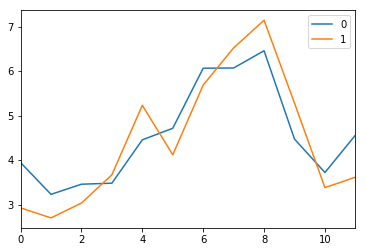

In [40]:
pd.DataFrame(T).plot()

In [25]:
from common import compute_rmse_fraction
out = {}
for algo in ['adagrad']:
    out[algo] = {}
    for a in range(2, 3):
        out[algo][a] = {}
        for random_seed in range(NUM_RANDOM):
            out[algo][a][random_seed] = {}

            for appliance in APPLIANCES_ORDER[1:]:
                out[algo][a][random_seed][appliance] = {}
                for f in TRAIN_SPLITS:
                    s = pd.concat(pred[algo][a][random_seed][appliance][f]).ix[df.index]
                    if appliance=="hvac":
                            out[algo][a][random_seed][appliance][f] = compute_rmse_fraction(appliance,s[range(4, 10)],'SanDiego')[2]
                    else:   
                        out[algo][a][random_seed][appliance][f] = compute_rmse_fraction(appliance, s,'SanDiego')[2]

    

/Users/nipunbatra/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  del sys.path[0]


In [32]:
pd.Panel(out['adagrad'][2]).mean(axis=0)

,dw,fridge,hvac,mw,oven,wm
10,1.810467,6.334669,16.248818,1.737886,2.083915,0.556813
50,1.825415,7.305924,17.177552,1.801521,2.109104,0.599455
90,1.851658,7.821781,19.284749,1.859911,2.186930,0.707624
